https://www.kaggle.com/datasets/mikoajfish99/lions-or-cheetahs-image-classification

In [1]:
import os
os.environ['HF_TOKEN'] ="hf_token"


In [2]:
import IPython
import sys

def clean_notebook():
    IPython.display.clear_output(wait=True)
    print("Notebook cleaned.")

# Run the installation commands
!pip install datasets
!pip install opendatasets
!pip install kaggle

# Clean up the notebook
clean_notebook()

Notebook cleaned.


In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mikoajfish99/lions-or-cheetahs-image-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/mikoajfish99/lions-or-cheetahs-image-classification


100%|██████████| 71.3M/71.3M [00:05<00:00, 14.7MB/s]


In [4]:
from datasets import load_dataset

raw_dataset = load_dataset("imagefolder", data_dir="./lions-or-cheetahs-image-classification")

raw_dataset

Resolving data files:   0%|          | 0/200 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 200
    })
})

# Train Test split

In [5]:
dataset = raw_dataset['train'].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 160
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 40
    })
})

In [6]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=737x1024>,
 'label': 0}

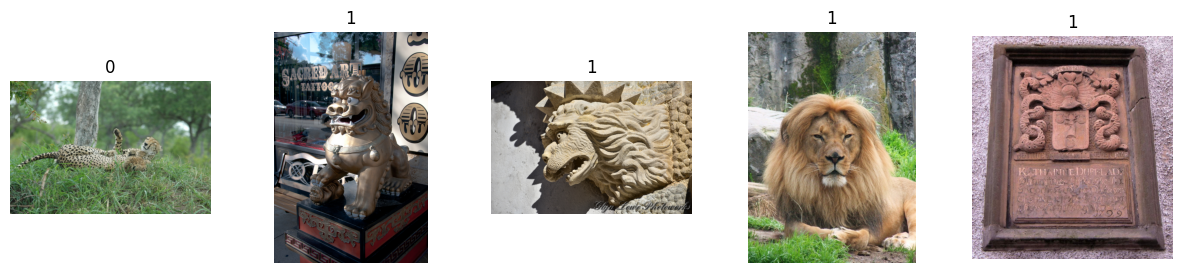

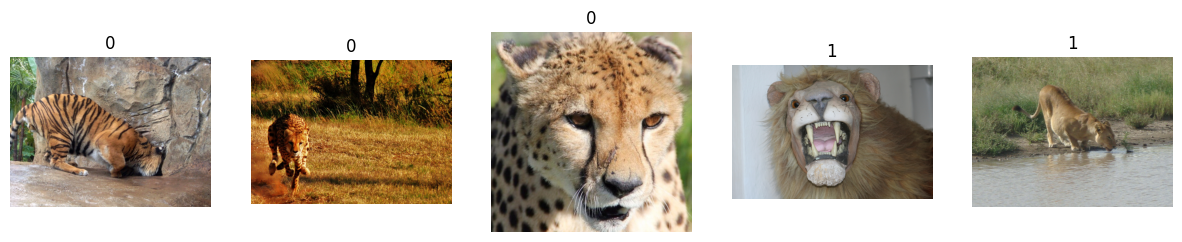

In [7]:
import matplotlib.pyplot as plt
import random

def show_images(dataset, num_images=5):
    plt.figure(figsize=(15, 3))
    indices = random.sample(range(len(dataset)), num_images)  # Randomly select indices
    for i, idx in enumerate(indices):
        image = dataset[idx]['image']
        label = dataset[idx]['label']  # Assuming each item in dataset has a 'label' key
        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(label)  # Add label as title for each subplot
    plt.show()

# Show some images from the training dataset
show_images(dataset['train'])
show_images(dataset['train'])

# Download the model from Hugging Face

In [8]:
import torch
import torch.nn as nn
from torchvision.models import resnet18
from huggingface_hub import PyTorchModelHubMixin

class CustomModel(nn.Module, PyTorchModelHubMixin):
    def __init__(self, config: dict):
        super().__init__()
        self.resnet = resnet18(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, config["num_classes"])

    def forward(self, x):
        return self.resnet(x)

checkpoint = "noteeb/custom-resnet18-model-eb"
# download from hub
loaded_model = CustomModel.from_pretrained(checkpoint)
loaded_model

config.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

C:\Users\noteh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\noteh\.cache\huggingface\hub\models--noteeb--custom-resnet18-model-eb. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\Users\not

model.safetensors:   0%|          | 0.00/44.8M [00:00<?, ?B/s]

CustomModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

# Create Dataset and Dataloder

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

import torch
import torch.nn as nn
import torch.optim as optim

# Custom dataset to apply transformations
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample['image'].convert("RGB")
        label = sample['label']

        if self.transform:
            image = self.transform(image)


        return image, label



# Define data augmentation transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


# Create train and test datasets with transformations
train_dataset = CustomDataset(dataset['train'], transform=transform)
test_dataset = CustomDataset(dataset['test'], transform=transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()]))


# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
for x,y in train_loader :
  print(x.shape,y.shape)
  break

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [11]:

# Training function
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

# Evaluation function
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(test_loader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc, all_labels, all_predictions


In [12]:
import matplotlib.pyplot as plt

num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(loaded_model.parameters(), lr=0.00005)

# Lists to store the accuracies for each epoch
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    train_loss, train_acc = train_model(loaded_model, train_loader, criterion, optimizer, device)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    # Append the train accuracy to the list
    train_accuracies.append(train_acc)

    # Evaluation
    test_loss, test_acc, all_labels, all_predictions = evaluate_model(loaded_model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    # Append the test accuracy to the list
    test_accuracies.append(test_acc)



Epoch [1/50], Train Loss: 0.8404, Train Accuracy: 0.5375
Test Loss: 0.5000, Test Accuracy: 0.8000
Epoch [2/50], Train Loss: 0.3632, Train Accuracy: 0.8250
Test Loss: 0.3333, Test Accuracy: 0.8250
Epoch [3/50], Train Loss: 0.2084, Train Accuracy: 0.9313
Test Loss: 0.3001, Test Accuracy: 0.8500
Epoch [4/50], Train Loss: 0.1073, Train Accuracy: 0.9688
Test Loss: 0.2888, Test Accuracy: 0.8500
Epoch [5/50], Train Loss: 0.1160, Train Accuracy: 0.9812
Test Loss: 0.2841, Test Accuracy: 0.8500
Epoch [6/50], Train Loss: 0.0828, Train Accuracy: 0.9875
Test Loss: 0.2760, Test Accuracy: 0.8500
Epoch [7/50], Train Loss: 0.0481, Train Accuracy: 0.9875
Test Loss: 0.2765, Test Accuracy: 0.8750
Epoch [8/50], Train Loss: 0.0379, Train Accuracy: 0.9938
Test Loss: 0.2765, Test Accuracy: 0.8500
Epoch [9/50], Train Loss: 0.0572, Train Accuracy: 0.9875
Test Loss: 0.2840, Test Accuracy: 0.8500
Epoch [10/50], Train Loss: 0.0165, Train Accuracy: 1.0000
Test Loss: 0.2896, Test Accuracy: 0.8750
Epoch [11/50], Trai

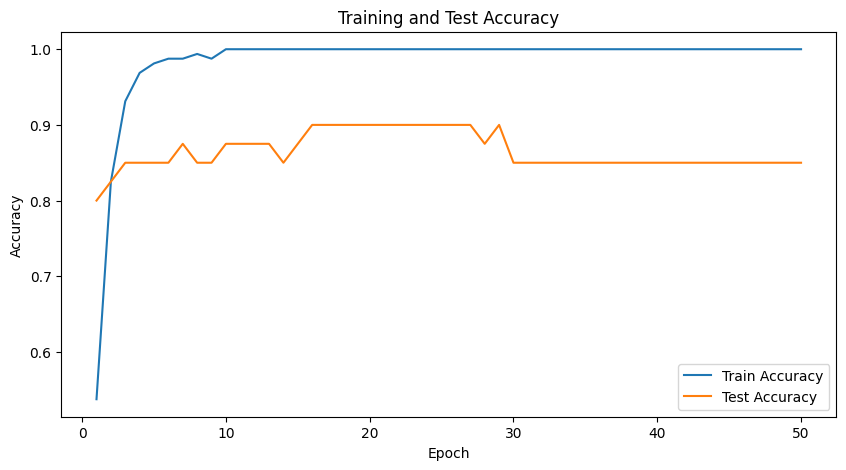

In [13]:

# Plot the accuracies
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Test Accuracy')
plt.show()


Test Loss: 0.0841, Test Accuracy: 0.9250


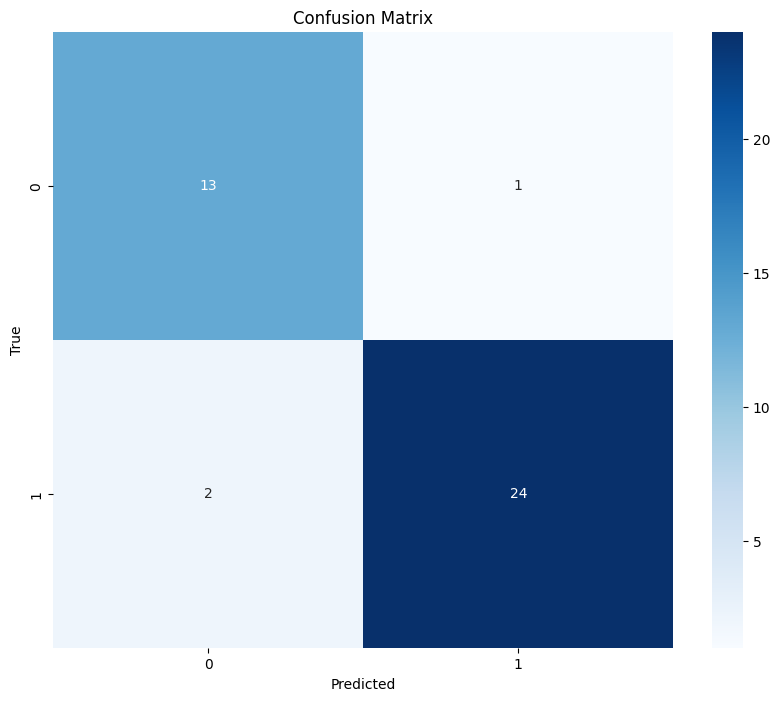

In [ ]:
# Evaluation

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


test_loss, test_acc, all_labels, all_predictions = evaluate_model(loaded_model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Push To Hub

In [14]:
# save locally

checkpoint = "custom-resnet18-model-eb2"

# Push the model to Hugging Face
loaded_model.push_to_hub(checkpoint)

model.safetensors:   0%|          | 0.00/44.8M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/NoteEB/custom-resnet18-model-eb2/commit/8618bd5214567f4a3d1f9f6d8bea8e75d5a60ee0', commit_message='Push model using huggingface_hub.', commit_description='', oid='8618bd5214567f4a3d1f9f6d8bea8e75d5a60ee0', pr_url=None, pr_revision=None, pr_num=None)